# TMA4320 Biophysics project
### Oliver Ruden, Åsmund Mjøs & Astrid Mysterud

Polymers are the building blocks of DNA, RNA and proteins. Polymers themselves consist of repeating units called monomers. In this project, polymers will be represented numerically in order to make energy calculations as the polymers rotate around their monomers. By using the Monte Carlo method, as described in the project description, we achieve rotations that account for realistic energy changes. The first part of the project mainly consists of creating functions needed for rudimentary polymer-functionality. The focus of the second part of the project is to investigate how rotations of the polymer and its energy varies under different conditions, such as temperature.

In this project, a polymer with $N$ monomers will be represented by a $N\times 2$-array containing the $N$ sets of $x$- and $y$-coordinates of their monomers. These $x$- and $y$-coordinates will all be bounded by $0\leq x,y \leq N+1$. 

The following function $\texttt{createPolymer}$, as described in task 1b), takes the argument $N$ and returns a polymer of size $N$ shaped as a horizontal line. To determine the $y$-coordinate, integer division is used.

In [48]:
# First, we import necessary libaries
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import timeit
plt.rcParams.update({'font.size': 20}) # change font-size of the plot

In [49]:
def createPolymer(N):
    """
    Create a straight polymer.
    Input:
    N: Length of the polymer
    """
    polymer = np.zeros((N, 2))
    """
    Put the monomers at a straight line at y = N/2 rounded down
    """
    polymer[:, 1] = N // 2                                
    polymer[:, 0] = np.array([x for x in range(N)])        
    return polymer                                        

In order to follow the rules that determine valid polymers, the energy will remain unchanged after a rotation around an endpoint. The energy of a polymer is determined by the distance between its monomers. When a polymer is rotated around an endpoint, its monomers do not receive any new neighbours, and as a result the energy of the polymer does not change. Rotating around the endpoints is also a physically meaningless rotation, since it does not change the structure of the polymer, it just changes the direction of which the polymer lies in the two-dimensional grid.

In algorithm $1$ and $2$ from the project description, we are to choose a random monomer to rotate around. To decrease the run time of the code, we've decided not to include rotation around edge monomers, since this does not change the physics of the polymer. As explained in the latter paragraph, the physical interpretation of rotating around the endpoints, as far as we know, is just changing the direction of which the polymer lies in the grid. Therefore, excluding rotation around endpoints wouldn't just improve the time of our code, but also give a better understanding of polymer behavior.

Inclusion and exclusion of edge monomers result in slighty different statistics, for example the percentage of legal rotations or the time it takes for an energy jump. This difference in statistics is negligible for larger polymers. However, for polymers of few monomers (e.g. under 10), this difference is significant. Since we have decided to exclude rotation around endpoints, it is important to be aware of this statistical difference.

The following code implements a function that visualizes the polymer, as asked for in task **1d)**. The polymer is shown in yellow/green squares showing its monomer number. To zoom in where the polymer is situated in the $N+1\times N+1$-grid, we illustrate the polymer in a grid that ranges from the minimum $x$-value to the maximum $x$-value held by a monomer, likewise in the $y$-direction.

We change the background value of the grid to $-N/2$, to better distinguish the polymer from the background, but also to still be able to uniquely identify monomers. Monomers with small indices are represented by darker blue/green, while monomers with greater indices are represented by brighter yellow.

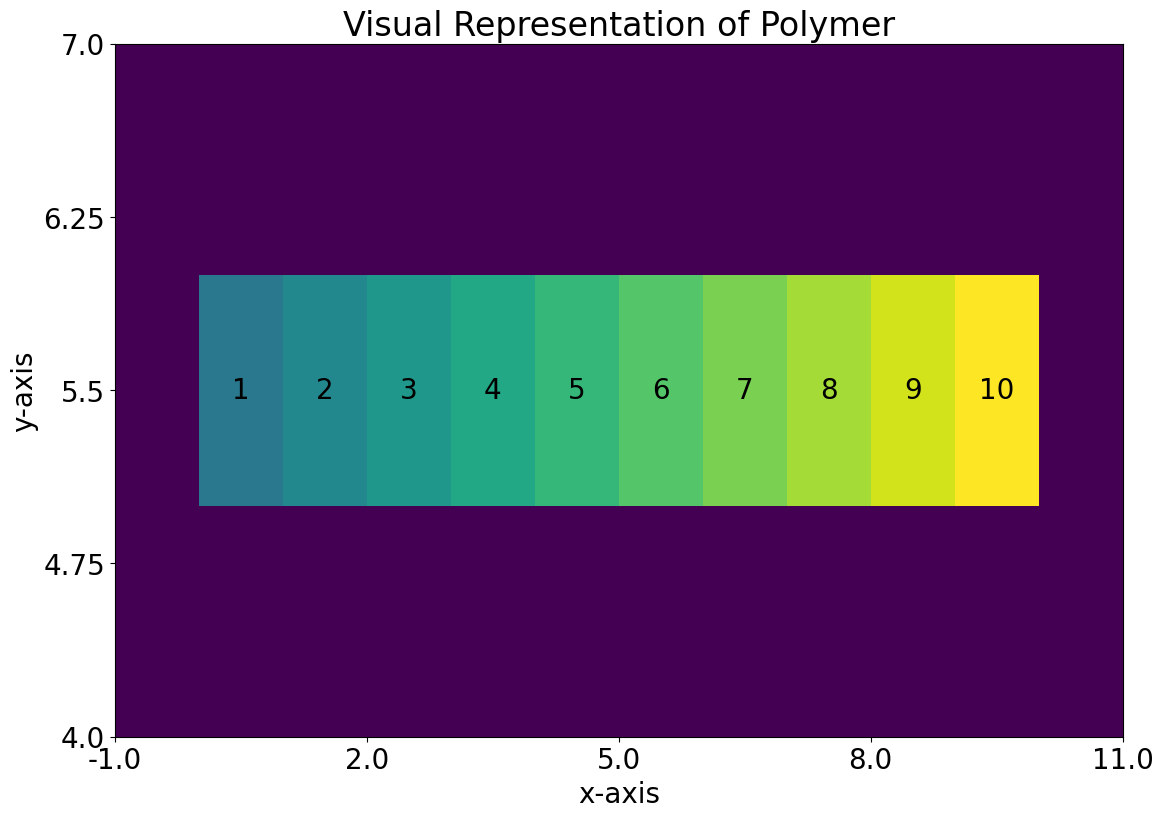

In [50]:
def illustratePolymer(polymer):
    """
    Illustrate a polymer in a 2-d grid where all non-occupied spaces have the same color and the occupied spaces have a color and number
    corresponding to their monomer-number
    Input:
    polymer: The polymer to illustrate
    """
    N = len(polymer)                                          
    """
    Find the x- and y-bounds of the grid
    """
    minx, maxx = np.min(polymer[:,0]), np.max(polymer[:,0])     
    miny, maxy = np.min(polymer[:,1]), np.max(polymer[:,1])
    """
    Initialize the grid with -N//2 as background value to highlight the polymer
    """
    grid = np.zeros((int(maxy-miny)+3, int(maxx-minx)+3))
    grid -= N//2                              

    """
    Customizing the plot
    """
    plt.figure(figsize = (13,9))
    plt.title("Visual Representation of Polymer")
    plt.xlabel(r"x-axis")
    plt.ylabel(r"y-axis")
    
    """
    Loop through all monomers of the input polymer and place their monomer number at the correct spot in the grid, both in term of text and value
    """
    for monomerNumber in range(N):                        
        x = int(polymer[monomerNumber, 0]-minx+1)         
        y = int(polymer[monomerNumber, 1]-miny+1)         
        grid[y, x] = monomerNumber + 1             
        plt.text(x+0.5,y+0.5,monomerNumber+1, ha = 'center', va = 'center')

    """
    Customize the axis so the correct coordinates are put
    """
    plt.xticks(ticks = np.arange(0,int(maxx-minx+3)+int(maxx-minx+3)/4,int(maxx-minx+3)/4),labels = np.arange(minx-1,minx-1+int(maxx-minx+3)+int(maxx-minx+3)/4,int(maxx-minx+3)/4))
    plt.yticks(ticks = np.arange(0,int(maxy-miny+3)+int(maxy-miny+3)/4,int(maxy-miny+3)/4),labels = np.arange(miny-1,int(maxy-miny+3)+int(maxy-miny+3)/4+miny-1,int(maxy-miny+3)/4))
    plt.pcolormesh(grid)
    plt.show()

""" 
Here, we visualize the horizontal polymer from task 1b) with N=10
"""
illustratePolymer(createPolymer(10))

While rotating a polymer around its monomers, one easily ends up with a polymer that does not meet the requirements as listed in task **1e)**. The following function receives a polymer and its size $N$, and checks whether it is valid or not. The function $\texttt{validPolymer}$ returns $\texttt{True}$ if the polymer is valid, and $\texttt{False}$ otherwise. To make sure that no monomers have the same coordinates, we initialize the set $\texttt{coordinateSet}$, where we add the monomer-coordinates as we loop through the monomers of the polymer. Once a monomer with already taken coordinates is encountered, $\texttt{validPolymer}$ returns $\texttt{False}$. If a monomer has unique coordinates $(x, y)$, the tuple $(x, y)$ is added to $\texttt{coordinateSet}$. To check that $m-1$ and $m+1$ are the closest neighbours of monomer $m$, we find the $x$- and $y$-distance to the monomer preceding $m$. If the sum of the $x$- and $y$-distance is not $1$, the preceding monomer cannot be one of the closest neighbours of $m$.

In [51]:
@jit
def validPolymer(polymer, N):
    """
    Check if a polymer is valid.
    Input:
    polymer: The polymer to check.
    N: The supposed length of the polymer.

    Check if the polymer has N monomers
    """
    if len(polymer) != N:                                      
        return False
    
    """
    Check if coordinates are unique, uses set and tuples for an average of constant time to check if an element in contained
    """
    coordinateSet = set()                                     
    coordinateSet.add((polymer[0, 0], polymer[0, 1]))          

    for monomerNumber in range(1, N):                          

        if (polymer[monomerNumber, 0], polymer[monomerNumber, 1]) in coordinateSet: 
            return False                                                            
        else: 
            coordinateSet.add((polymer[monomerNumber, 0], polymer[monomerNumber, 1]))

        """
        Check taxicab-distance, should be 1 for neighbours.
        """
        xDiff = np.abs(polymer[monomerNumber, 0] - polymer[monomerNumber - 1, 0])     
        yDiff = np.abs(polymer[monomerNumber, 1] - polymer[monomerNumber - 1, 1])     
        if xDiff + yDiff != 1:   
            return False          
        
    return True    

Next, we are to implement rotation for the polymer. Task **1f)** states that the function should have the following input parameters: a polymer, a coordinate of a monomer, and the direction of rotation. In algorithm $1$ and $2$, which use the function that rotates the polymer, a random monomer is chosen to rotate around. We find it faster and much simpler to find a random monomer number to rotate around, rather than a random coordinate to rotate around. By following the task syntax, our randomization code would generate monomer number, go to coordinate, and then the rotating function $\texttt{rotatePolymer}$ would go back to monomer number. $\texttt{rotatePolymer}$ goes back to monomer number, so that we can easily break the polymer into two pieces: one to remain in place, and one that will be rotated. That is why we have implemented the function $\texttt{rotatePolymer}$ to not have input parameter coordinate, but rather monomer number. If $\texttt{rotatePolymer}$ had monomer coordinate as input, the monomer number could be collected as shown in the following function $\texttt{coordToMonomerNumber}$. $\texttt{coordToMonomerNumber}$ receives an input polymer and coordinate, and returns monomer number. This way we could have just had input parameter monomer coordinate in $\texttt{rotatePolymer}$ and found monomer number from $\texttt{coordToMonomerNumber}$.

In [52]:
def coordToMonomerNumber(polymer, coord):
    """
    To convert a coordinate in a polymer to a monomer number
    Input:
    polymer: The polymer which containes the coordinate
    coord: The coordinate which to find the corresponding monomer number
    """
    for monomerNumber in range(len(polymer)):
        if polymer[monomerNumber].all() == np.array(coord).all():
            return monomerNumber + 1
    return None

Next code block implements the rotating function $\texttt{rotatePolymer}$. The function $\texttt{rotatePolymer}$ receives an input polymer and a monomer number which the polymer will rotate around. $\texttt{rotatePolymer}$ also receives a boolean $\texttt{positiveDirection}$. $\texttt{positiveDirection=True}$ rotates the polymer in the positive direction, while $\texttt{positiveDirection=False}$ rotates the polymer in the negative direction. 

The placement of each monomer in the polymer after a rotation around a monomer $m_{rot}$, is determined by it's relative distance in $x$-direction $\Delta x$ to $m_{rot}$ and it's relative distance in $y$-direction $\Delta y$ to $m_{rot}$. We look at the monomers positions relative to $m_{rot}$ as free vectors, and since we will either be rotating them in positive or negative direction, we can simply multiply by the rotation matrix, either positive direction, or negative direction.

In positive rotation, the original vector $(1,0)$ will go to $(0,1)$ and the vector $(0,1)$ will go to $(-1,0)$. In negative rotation, the original vector $(1,0)$ will go to $(0,-1)$ and $(0,1)$ will go to $(1,0)$ in negative rotation. This is essentially all the information we need to implement rotation, since rotation is a linear operation, and these two vectors forms an orthonormal basis for $\mathbb{R}^2$.

To decrease runtime, $\texttt{rotatePolymer}$ is compiled by using $\texttt{@jit}$ from the $\texttt{numba}$-library. *mer om hvorfor jit*

In [53]:
@jit
def rotatePolymer(polymer, monomer, positiveDirection):
    """
    Rotates a polymer at a given monomer in the direction specified.
    Input:
    polymer: The polymer to rotate
    monomer: The monomer to rotate the polymer around (1-indexed, as we decided previously)
    positiveDirection: It is 1 if we are supposed to rotate in the positive direction, and 0 for rotation in the negative direction. 


    Setting up for rotation by finding the index of the monomer and its x and y coordinates, alongside finding the index of the middle and
    initializing a new polymer array, as working inplace makes undoing the rotation if it is invalid more difficult. 
    """
    monomer -= 1                                           
    middleMonomer = len(polymer) // 2                       
    x, y = polymer[monomer]                                 
    newPolymer = np.zeros((len(polymer),2))                 

    if middleMonomer > monomer:
        """
        If the monomer is on the left half of the polymer array, the right side of the monomer is copied over, while the left is rotated using
        the rotation matrix.
        """
        newPolymer[monomer:] = polymer[monomer:]
        newPolymer[:monomer, 0] = (2 * positiveDirection - 1) * (polymer[:monomer, 1] - y) + x
        newPolymer[:monomer, 1] = (1 - 2 * positiveDirection) * (polymer[:monomer, 0] - x) + y
        """
        Positive direction:
        delta x = delta y
        delta y = - delta x
        Negative direction:
        delta x = - delta y
        delta y = delta x

        Also uses that True is represented as 1 and False as 0.
        """
        return newPolymer
    """
    If the monomer is on the right half of the polymer array, the left side of the monomer is copied over, while the right is rotated using
    the rotation matrix.
    """
    newPolymer[:monomer+1] = polymer[:monomer+1]
    newPolymer[monomer+1:,0] = (1-2*positiveDirection)*(polymer[monomer+1:,1]-y)+x
    newPolymer[monomer+1:,1] = (2*positiveDirection-1)*(polymer[monomer+1:,0]-x)+y
    """
        Positive direction:
        delta y = delta x
        delta x = - delta y
        Negative direction:
        delta y = - delta x
        delta x = delta y
    """
    return newPolymer


Now that a polymer is able to rotate, we implement functionality to rotate multiple times as described in task **1g)**. $\texttt{rotateNTimes}$ implements algorithm $1$ from the project description and takes in the polymer size $N$ and the number of wanted rotations $N_s$.

In [54]:
def rotateNTimes(N, Ns):
    """
    Attempt to rotate a polymer of length N Ns times.
    Input:
    N: The length of the polymer to rotate
    Ns: The number of rotation to attempt
    """
    rotationsMade = 0
    polymer = createPolymer(N)

    """
    Attempting to use rotatePolymer Ns times, 
    checking if the rotated polymer is valid or not
    """
    for i in range(Ns):
        monomer = np.random.randint(2, N)
        positivRetning = np.random.randint(0, 2)

        twistedPolymer = rotatePolymer(polymer, monomer, positivRetning)
        if validPolymer(twistedPolymer, N):
            rotationsMade += 1
            polymer = twistedPolymer

    """
    Returning rotated polymer and the number of valid rotations
    """
    return polymer, rotationsMade

For å kunne illustrere og sammenligne sluttresultatet til to polymerer på en hensiktsmessig måte implementerer vi plottefunksjonen fra oppgave **2c)** her

In [55]:
def illustrationOfOnePolymer(polymer):
    """
    Input:
    polymer: The polymer to create a grid for
    """
    N = len(polymer)                               # calculate the size of the input polymer
    """
    Getting the dimensions of the needed grid by finding the min and max value for both the x and y axis. 
    """
    minx, maxx = np.min(polymer[:,0]), np.max(polymer[:,0])
    miny, maxy = np.min(polymer[:,1]), np.max(polymer[:,1])
    """
    Creating the grid and placing the monomers in the middle, with the non-occupied spaces having a value of N/2 rounded down and the monomers
    having the value of their monomerNumber (1,...,N)
    """
    grid = np.zeros((int(maxy-miny)+3, int(maxx-minx)+3))               
    grid -= N//2     
    for monomerNumber in range(N):                 # loop through all monomers of the input polymer
        x = int(polymer[monomerNumber, 0]-minx+1)         # collect x-coordinate of the monomer relative to the grid
        y = int(polymer[monomerNumber, 1]-miny+1)         # collect y-coordinate of the monomer relative to the grid
        grid[y, x] = monomerNumber + 1    
    return grid,minx,maxx,miny,maxy



def multiplePlotsPolymers(polymer1,polymer2, title1,title2):
    """
    Input:
    polymer1, polymer2: The two polymers to be illustrated
    title1, title2: The title over the respective plots of the polymers
    """
    fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13,5)) #Initialising two plots next to each other

    #Sublot 1
    """
    Getting the correct grid and plotting the data in a pcolormesh for the first polymer
    """
    N = len(polymer1)
    grid_1,minx,maxx,miny,maxy = illustrationOfOnePolymer(polymer1)
    ax1.pcolormesh(grid_1)
    ax1.set(title = title1)
    """
    Placing the monomer-numbers over the monomers in the plot for the first polymer.
    """
    for monomerNumber in range(N):
        x = int(polymer1[monomerNumber, 0]-minx+1)         
        y = int(polymer1[monomerNumber, 1]-miny+1)                
        ax1.text(x+0.5,y+0.5,monomerNumber+1, ha = 'center', va = 'center')
    """
    Customising the axis for the first polymer, so that the correct x and y coordinates are illustrated
    """
    ax2.set_xticks(ticks = np.arange(0,int(maxx-minx+3)+int(maxx-minx+3)/4,int(maxx-minx+3)/4),labels = np.arange(minx-1,minx-1+int(maxx-minx+3)+int(maxx-minx+3)/4,int(maxx-minx+3)/4))
    ax2.set_yticks(ticks = np.arange(0,int(maxy-miny+3)+int(maxy-miny+3)/4,int(maxy-miny+3)/4),labels = np.arange(miny-1,int(maxy-miny+3)+int(maxy-miny+3)/4+miny-1,int(maxy-miny+3)/4))    
    #Subplot 2
    """
    Getting the correct grid and plotting the data in a pcolormesh for the first polymer
    """
    N = len(polymer2)
    grid_2,minx,maxx,miny,maxy = illustrationOfOnePolymer(polymer2)
    ax2.pcolormesh(grid_2)
    ax2.set(title = title2)
    """
    Placing the monomer-numbers over the monomers in the plot for the second polymer.
    """
    for monomerNumber in range(N):
        x = int(polymer2[monomerNumber, 0]-minx+1)         
        y = int(polymer2[monomerNumber, 1]-miny+1)                  
        ax2.text(x+0.5,y+0.5,monomerNumber+1, ha = 'center', va = 'center')
    """
    Customising the axis for the second polymer, so the correct x and y coordinates are illustrated
    """
    ax2.set_xticks(ticks = np.arange(0,int(maxx-minx+3)+int(maxx-minx+3)/4,int(maxx-minx+3)/4),labels = np.arange(minx-1,minx-1+int(maxx-minx+3)+int(maxx-minx+3)/4,int(maxx-minx+3)/4))
    ax2.set_yticks(ticks = np.arange(0,int(maxy-miny+3)+int(maxy-miny+3)/4,int(maxy-miny+3)/4),labels = np.arange(miny-1,int(maxy-miny+3)+int(maxy-miny+3)/4+miny-1,int(maxy-miny+3)/4))
    """
    Plot the two colormeshes
    """
    plt.show()


A polymer of length N=15 trying to rotate Ns=4 times, had 4 successful rotations.
A polymer of length N=15 trying to rotate Ns=1000 times, had 590 successful rotations.


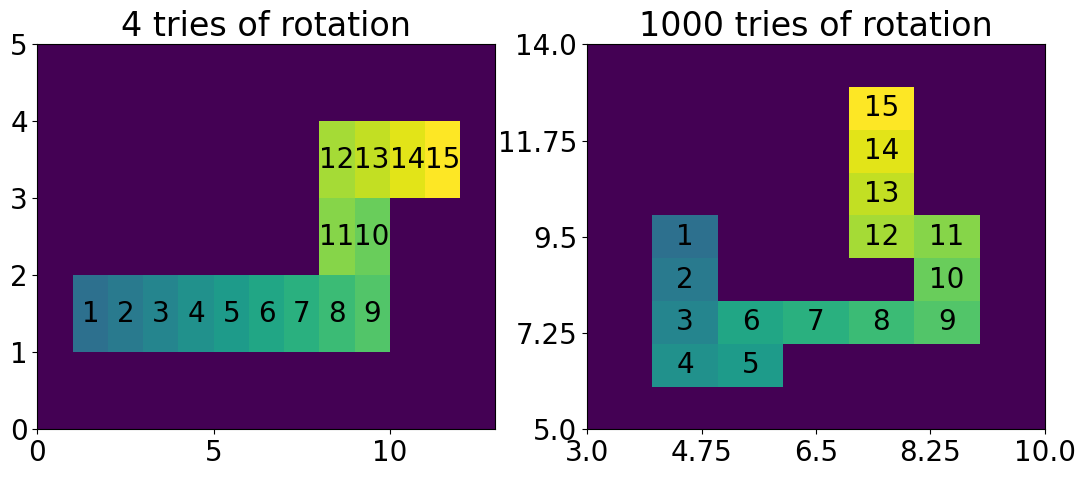

In [56]:
"""
Testing the function rotateNtimes with N=15 and Ns=4, and N=15 and Ns=1000 and plotting the result. 
Also saving the final position of the polymer for a later task with numpy.savetxt,
since this is how we would do it if we were operate in different files.
This is just one jupyter notebook, so we find it adequate to just reach them by calling their array-names:
'polymerN4' and 'polymerN1000'

Ns=4:
"""

polymerN4, rotationsN4 = rotateNTimes(15, 4)
print(f"A polymer of length N=15 trying to rotate Ns=4 times, had {rotationsN4} successful rotations.")
np.savetxt('polymerArray15_4.txt', polymerN4)
"""
Ns=1000:
"""

polymerN1000, rotationsN1000 = rotateNTimes(15,1000)
print(f"A polymer of length N=15 trying to rotate Ns=1000 times, had {rotationsN1000} successful rotations.")
np.savetxt('polymerArray15_1000.txt', polymerN1000)

multiplePlotsPolymers(polymerN4, polymerN1000, "4 tries of rotation", "1000 tries of rotation")

One of the main problems within the computation time as of now is the time it takes to rotate the polymer. With the implementation we have used up to now, we split the cases so that we always only rotate the shorter side of the polymer. Thus on average, the length of the chain we rotate will be $N/2\cdot1/2 = N/4$. As we change both the $x$- and the $y$-value for each of these every time, we alter $N/2$ numbers on average each time. To lower this number, we reimplement the structure of the polymer. Instead of having an $N\times 2$ array which tracks the polymers coordinates, we use the fact that the polymer must be connected. 

Thus, we create our own object called $\texttt{Middle}$, which tracks the $x$- and $y$-coordinates of the middle monomer and also contains two arrays. The first, called $\texttt{beforeMiddle}$, is of length number of monomers left of the middle, and it contains a singular element in each slot, namely the direction the next monomer is, relative to where one came from. $0$ means straight forward, $1$ means to the right and $3$ means to the left. Similarly, $\texttt{afterMiddle}$ does the same for the right side, just that $2$ means straight forward, $1$ means to the left and $3$ means to the right. Finally, we have also assigned $\texttt{Middle}$ with a map, just to easily keep the data together, the map maps from direction number to correct movement in the cartesian plane. 

This new implementation speeds up the rotation algorithm, as instead of changing on average $N/2$ datapoints, we only need to rotate one “pointer”, as then the relative distance for all points more extreme will also be moved. Furthermore, this also keeps the invaluable property that the middle always is in the center, as all pointers point from the center to the extremes. This was made possible by changing the polymer in-place, and thus avoiding copying the entire array. To change the polymer in-place was made possible by implementing an else in the $\texttt{rotateManyTimes}$. If the new polymer wasn’t legal, one would just rotate the polymer on the same monomer in the other direction. To do things like illustrate the polymer, we just start from the middle and illustrate each end by keeping track of the position we are at, which way we look and which way the pointer wants us to move. Thus, we can always construct the appropriate $x$- and $y$-coordinates in linear time, which is more than fast enough as all algorithms that need the $x$- and $y$-coordinates use linear time regardless, and results tell us that the algorithms that take linear time like for instance to check if a polymer is valid, often operate faster with the new implementation. As can be observed in the following code, this new implementation almost halves the computational time of $\texttt{rotateManyTimes}$.

In [57]:
class Middle:
    def __init__(self, x, y, N):
        self.position = np.array([x,y]) # Position of the middle
        self.beforeMiddle = np.array([0 for i in range(N//2)]) # Left tail of the polymer from the middle
        self.afterMiddle = np.array([2 for i in range((N-1)//2)]) # Right tail of the polymer from the middle
        self.map = {0:np.array([0,-1]), 1:np.array([1,0]), 2:np.array([0,1]),3:np.array([-1,0])} # Map of direction to Cartesian-coordinates change

"""
1 b) This is a new createPolymer designed around the new implementation of a polymer
"""
def createPolymerVer2(N):
    middle = Middle(N//2, N//2, N)    # Initializes the class
    return middle
"""
1 d) This is a new way to illustrate the polymer using the same principles as above but with the new implementation in mind
"""
def illustrationPolymerVer2(polymer):
    """
    Illustrating the polymer with the new representation. We could have implemented the illustration as above, with zoomed in, but as the focus
    of this new implementation is to make the program faster, and as we later conclude to abandon this version, it was concluded that a proof of
    concept, that one could illustrate the second polymer implementation relatively efficient, was sufficient. 


    Input:
    polymer: The polymer to illustrate

    As the endpoints aren't included in the two arrays in the implementation of the polymer, but the middle is included twice, the total length
    should be the sum of the lengths of the arrays plus 1. 
    """
    N = len(polymer.beforeMiddle) + len(polymer.afterMiddle) + 1        
    """
    Initializing the grid and setting the default value to be -N/2 rounded down
    """
    grid = np.zeros((N+1,N+1))        
    grid -= N//2                         
    index = N//2
    position = np.copy(polymer.position)
    direction = 0
    """
    Traversing the left tail of the polymer from the middle, and setting the value in the grid as the monomer number. The starting direction is
    0 (to the left)
    """
    for firstMonomers in range(index-1,-1,-1):
        """
        Updating the direction to traverse, realising that as the default is to the right, upwards should decrease one from the direction and
        downwards should add one. Then traversing one that direction
        """
        direction = (direction + polymer.beforeMiddle[firstMonomers])%4
        position += polymer.map[direction]
        grid[position[0],position[1]] = firstMonomers + 1
    direction = 2
    position = np.copy(polymer.position)
    """
    Setting the grid value for the middle monomer
    """
    grid[position[0],position[1]] = index + 1
    """
    Traversing the right tail of the polymer from the middle, and setting the value in the grid as the monomer number. The starting direction is
    2 (to the right)
    """
    for secondMonomers in range(0, len(polymer.afterMiddle)):
        """
        Traversing the right tail of the polymer from the middle, and setting the value in the grid as the monomer number. The starting direction is
        2 (to the right)
        """
        direction = (direction + polymer.afterMiddle[secondMonomers]-2)%4
        position += polymer.map[direction]
        grid[position[0],position[1]] = secondMonomers+ index + 2
    plt.pcolormesh(grid)
    plt.show()

"""
1 e) Checks if the polymer is intact and legal
"""

def validPolymerVer2(polymer, N):
    """
    Checking if the polymer is valid, given the restrictions presented in the problemset
    Input:
    polymer: The polymer to check
    N: The supposed length of the polymer

    Checking if the monomer with monomer number m are closest neighbours with the monomers with monomer numbers m pm 1 is unnecessary,
    since this version of representation is based on telling the monomers which direction they are supposed to go 1 unitlength in.

    Here we check whether the polymer is of correct length, as the two arrays doesnt account for the end points but also including the middle
    twice, the total length of the two arrays should be 1 less than N
    """
    if len(polymer.beforeMiddle) + len(polymer.afterMiddle) + 1 != N: 
        return False
    """
    Create a set to store the coordinates of the monomers. The datastructure set is chosen because of the O(1) average look up time compared to 
    the O(n) of for instance a list. The middle is added to the set
    """
    coordinateSet = set()
    coordinateSet.add((polymer.position[0], polymer.position[1]))
    index = N//2
    position = np.copy(polymer.position)
    direction = 0
    """
    Checking the left tail of the array first. Thus, we start looking to the left direction and traversing outwards.
    """
    for firstMonomers in range(index-1,-1,-1):
        """
        Checking if the direction of traversing is valid
        """
        if polymer.beforeMiddle[firstMonomers] not in polymer.map: 
            return False
        """
        Updating the direction to look and traversing that direction
        """
        direction = (direction + polymer.beforeMiddle[firstMonomers])%4
        position += polymer.map[direction]
        """
        If the new coordinate is in the set, abort as we have an overlap, else, add the new coordinate to the set
        """
        if (position[0],position[1]) in coordinateSet: #Checks if there exists an overlap of coordinates
            return False
        else:
            coordinateSet.add((position[0],position[1]))
    direction = 2
    position = np.copy(polymer.position)
    """
    Initialising for the right tail, with starting direction to the right (2)
    """
    for secondMonomers in range(0,len(polymer.afterMiddle)):
        """
        If the direction is invalid, return false
        """
        if polymer.afterMiddle[secondMonomers] not in polymer.map: 
            return False
        """
        Updating the direction to traverse, realising that as the default is to the right, upwards should decrease one from the direction and
        downwards should add one. Then traversing one that direction
        """
        direction = (direction + polymer.afterMiddle[secondMonomers]-2)%4
        position += polymer.map[direction]
        """
        If the new coordinates is in the set, return false as there is an overlap, else add the coordinate to the set
        """
        if (position[0],position[1]) in coordinateSet: #Checks if there exists an overlap of coordinates
            return False
        else:
            coordinateSet.add((position[0],position[1]))
    """
    If all conditions passed, then the polymer must be valid
    """
    return True

"""
1 f) Implementation of rotation, as previously, the middle rounded upwards is kept at a constant position
"""
def rotationGoBrrrrVer2(polymer, monomer, positivRetning):
    """
    Note that neither the first nor the last monomer in the polymer is represented in the array, and that also we call the monomers by 1-indexing
    Thus we need to subtract two to both account for the first monomer not being in the array, and also for that we go from 1-indexing to 0-indexing
    """
    monomer -= 2
    middleMonomer = len(polymer.beforeMiddle)-1 #Finds the middle rounded up 
    if middleMonomer > monomer: #Checks if we are before the middle
        polymer.beforeMiddle[monomer] = (polymer.beforeMiddle[monomer] + 2*positivRetning-1) % 4
        """
        Positive direction:
        direction = direction + 1
        Negative Direction:
        direction = direction - 1
        
        Then readjust so that for instance right from pointing downwards is left, not an undefined value

        Follows from that the direction number increases in the negative direction
        """
        return polymer
    polymer.afterMiddle[monomer-middleMonomer] = (polymer.afterMiddle[monomer-middleMonomer] - 2*positivRetning+1) % 4
    """
    Positive direction:
    direction = direction - 1
    Negative Direction:
    direction = direction + 1

    Then readjust so that for instance right from pointing downwards is left, not an undefined value

    Follows from that the direction number increases in the negative direction
    """
    return polymer

"""
1 g) This is the reimplementation of the similar algorithm above, with the key difference being what happens when a rotation doesn't work.
Here we undo the rotation by giving the same polymer and monomer, just the opposite rotation direction. This is necessary as we edit the polymer
in place, and thus can't just discard the changes. 
"""
def rotateNTimesVer2(N, Ns):
    """
    Rotate a polymer of length N Ns times
    Input:
    N: The length of the polymer
    Ns: The number of attempted rotations
    """
    rotationsMade = 0
    polymer = createPolymerVer2(N)
    """
    Attempt Ns rotations
    """
    for i in range(Ns):
        """
        Randomly choose a monomer to rotate and a direction to rotate it in
        """
        monomer = np.random.randint(2, N)
        positivRetning = np.random.randint(0,2)

        polymer = rotationGoBrrrrVer2(polymer, monomer, positivRetning)
        """
        If the new polymer is valid, add another rotation, else, rotate it back
        """
        if validPolymerVer2(polymer, N):
            rotationsMade += 1
        else:
            polymer = rotationGoBrrrrVer2(polymer,monomer,(positivRetning+1)%2)

    return polymer, rotationsMade

"""
Here is a comparrison of the old rotateManyTimes and rotateManyTimesVer2
"""
# %timeit rotateNTimes(150, 10000)
# %timeit rotateNTimesVer2(150,10000)

'\nHere is a comparrison of the old rotateManyTimes and rotateManyTimesVer2\n'


Note, that here, $\texttt{rotateNTimes}$ uses $\texttt{@jit}$ while $\texttt{rotateNTimesVer2}$ doesn't, thats why $\texttt{rotateNTimesVer2}$ is much slower than $\texttt{rotateNTimes}$. Without $\texttt{@jit}$, $\texttt{rotateNTimesVer2}$ is approximetly twice as fast as $\texttt{rotateNTimes}$ (tested previously, but not in this code). If we managed to get $\texttt{@jit}$ to work for $\texttt{rotateNTimesVer2}$, it probably would be faster by a similar factor of two, but it is more difficult as $\texttt{rotateNTimesVer2}$ uses an own defined object, making it more difficult. However, because we have made it to work for the old implementation, and that the old implementation is much more clear and sufficiently quick, we have chosen to abandon the second implementation, and continue focusing on the old implementation. 

The function $\texttt{rotateNTimes}$ receives the argument $\texttt{Ns}$, which is the number of rotations we wish to complete. However, since we encounter several non-valid polymers while rotating many times, we want to see how many of those $\texttt{Ns}$ rotations actually resulted in valid polymers. $\texttt{rotateNTimes}$ returns $\texttt{rotationsMade}$, which tells us how many rotations resulted in a valid polymer. The following function, as described in **1i)**, plots the percentage of valid rotations as a function of the size $N$ of the polymer. $\texttt{plotValidPercentage}$ receives $\texttt{minSize}$ and $\texttt{maxSize}$, which are the minimum and maximum sizes of the polymers we are to rotate. $\texttt{minSize}$ and $\texttt{maxSize}$ are by default set to $10$ and $500$, respectively. $\texttt{plotValidPercentage}$ also has the input $\texttt{NsArray}$, which is an array of the different $\texttt{Ns}$ we want to test. $\texttt{NsArray}$ is default set to $1000$ rotations.

In [58]:
def plotValidPercentage(minSize = 10, maxSize = 500, NsArray = np.array([1000])):
    """
    Plotting the valid percentages as a function of polymer lengths for different amounts of attempted rotations
    Input:
    minSize: The shortest polymer to simulate for a range with interval-sizes of 10
    maxSize: The longest polymer to simulate for the range
    NsArray: The different number of rotations attempted, each of these will be used to plot percentage of successfull rotations as a function of polymer size
    """
    sizes = np.arange(minSize, maxSize + 1, 10)     
    intSizes = sizes.astype(int)                    
    """
    Initialising the plot
    """
    plt.figure(figsize = (10, 7))
    """
    Simulating the rotations and plotting the percentage of valid rotations
    """
    for Ns in NsArray:
        validRotations = np.array([rotateNTimes(N, Ns)[1] for N in intSizes])
        plt.plot(intSizes, (validRotations / Ns) * 100, label = f'Ns = {Ns}')    
    """
    Customizing the plot
    """
    plt.xlabel(r'Polymer Size $N$')
    plt.ylabel('Percentage of Valid Rotations')
    plt.title('Valid Rotations Made as a Function of Polymer Size $N$') 
    plt.legend()
    plt.show()

# plotValidPercentage(10, 100, np.array([500, 1000, 50000, 100000]))

*Diskusjon av Ns*
With $\texttt{Ns=1000}$ for polymers of size between $\texttt{minSize=10}$ and $\texttt{maxSize=500}$, the plot above shows that we achieve more valid rotations for smaller $N$. However, at around $N=100$ the percentage of valid rotations stabilizes between $40\%$ and $47.5\%$. By increasing $\texttt{Ns}$, we get the following result.

As described in task **1j)**, we now implement energy calculations. The following function $\texttt{calculateEnergy}$ receives a polymer and a matrix $V$. The matrix $V$ is, as described in the project description, a symmetric matrix that contains the strengths of the interactions between monomers.

*Mer om V*

To calculate the energy of each polymer, there are three major ideas behind our design of the energyalgorithm. Firstly, we have realised that if monomers $x$ and $y$ are neighbours, with $y>x$ and $x,y\in\mathbb{Z}^+$, we only need to catch that $y$ is neighbour to $x$. This is because the potential is symmetrical, and thus instead of adding half of the potential for each of them, we just add the entire potential when we discover that $y$ is a neighbour to $x$. Secondly, we discovered that it doesn't matter that we discover that $m$ is a neighbour with $m-1$, as adding the potential between them will just be adding 0. Thirdly, we discovered that it doesnt matter if we store all potential neighbours to a coordinate as a list and loop over them, as a point can maximum have 4 neighbours, and thus one only needs to loop over 4 values regardless. Thus, our design method of the algorithm is that we start at the beginning of the polymer, and for each monomer, we log which coordinates the monomer is neighbour to, and save these data in a dictionary where the key is a coordinate, and the values are the monomers discovered so far that are neighbours to this coordinate. As dictionaries are hash-tables in python, each coordinate has finite neighbours and each monomer has finite coordinate-neighbours, each iteration over a monomer should take constant time, and calculateEnergy should average $\theta(n)$, which seems reasonable to be as efficient in asymptotic notation as this algorithm can be.

In [59]:
def calculateEnergy(polymer, V):
    """
    Calculate the energy of the polymers
    Input:
    polymer: The polymer to calculate the energy for
    V: The potential used to calculate the energy
    """
    energy = 0
    neighbourDict = {}
    direction = [[0, 1], [0, -1], [1, 0], [-1, 0]]
    """ 
    Loop over the monomers in the polymers, and checking if they are neighbours
    """
    for monomerNumber, coordinates in enumerate(polymer):
        cordTuple = (coordinates[0], coordinates[1])            
        """
        Checking if the coordinates of the monomer makes it neighbour with any previously checked monomers.
        """
        if cordTuple in neighbourDict:                          # 
            for n in neighbourDict[cordTuple]:
                energy += V[monomerNumber,n]
        """
        Adding the neighbouring spaces of the monomer to the neighbourdictionary, in case one of the later monomers are on one of these spots
        """
        for vec in direction:
            temp = (coordinates[0] + vec[0], coordinates[1] + vec[1])

            if temp in neighbourDict:
                neighbourDict[temp].append(monomerNumber)
            else:
                neighbourDict[temp] = [monomerNumber]
    """
    Returning the energy
    """
    return energy

We want to use this function to calculate the energy of the two polymers from task **1g)**. As task **1j)** asks, we use a $V$-matrix where all non-zero elements are $-1$. First, we define the function $\texttt{makePotential}$, to easily make the matrix $V$.

In [60]:
def makePotential(N, backgroundValue):
    """
    Make a potential matrix:
    Input:
    N: The size of the polymer, and thus the length of each side of the potential matrix
    backgroundValue: The value of all cells not supposed to be 0 (the cells representing the interaction of monomer m with monomers m-1,m,m+1)
    """
    V = np.zeros((N, N)) + backgroundValue
    """
    Setting the correct cells to 0
    """
    for m in range(N):
        V[m, m] = 0
        if m > 0:
            V[m, m - 1] = 0
            V[m - 1, m] = 0

    return V


In [61]:
"""
From Task 1g)
"""

print("From task 1g)\n")

VN4 = makePotential(len(polymerN4), backgroundValue=-1)

print(f'The energy of the polymer with 4 attempts of rotation is {calculateEnergy(polymerN4, VN4)}')

VN1000 = makePotential(len(polymerN1000), backgroundValue=-1)

print(f'The energy of the polymer with 1000 attempts of rotation is {calculateEnergy(polymerN1000, VN1000)}')

From task 1g)

The energy of the polymer with 4 attempts of rotation is -2.0
The energy of the polymer with 1000 attempts of rotation is -1.0


The polymer with 4 tries of rotation often has a smaller absolute energy than the polymer with 1000 tries of rotation. This does intuitively make sense, since 4 rotations often isn't enough to curl the polymer into something ball-like, that has a lot of neighbours. 1000 is plenty though, and even though it wouldn't randomly make a ball, it does seem intuitive that segments of the polymer would seem cramped up, giving lots of neighbours, for example if there are 2 consecutive positive rotations next to each. We would however expect to see quite a lot of cases where the opposite is true, since the 1000 rotations often can counteract each other. 

### Task 2

That concludes the first part of the project, i.e. implementing polymer functionality. Moving on to part $2$, this functionality will be used to create realistic rotations and investigate energy at different temperatures. Now that we have a function that can calculate the energy of a given polymer, we can start to simulate a polymer through a Monte-Carlo simulation. The Monte-Carlo simulation, as described in algorithm $2$, takes the fact that a polymer want to achieve lower energy into account, as well as considering energy rises due to thermal fluctuations. 

Before implementing algorithm $2$ in the function $\texttt{metropolisAlgorithm}$, we start by implementing a function that calculates a polymers diameter. This is done considering a later task, **2g)**, where we are to add diameter calculations to our implementation of algorithm $2$. The function $\texttt{calculateDiameter}$ finds the longest cartesian distance between two monomers of the polymer. Thus, for instance, a polymer that's of dimensions $1\times N$ will get a diameter of $N-1$ as the longest distance would be between the midpoints of the edge monomers. $\texttt{calculateDiameter}$ has only one argument, which is a polymer. Our algorithm checks the distance between all pair of monomers and returns the largest distance. This is not a time efficient algorithm, we therefore use $\texttt{@jit}$ again to reduce the runtime.

In [62]:
@jit
def calculateDiameter(polymer):
    """
    Calculate the diameter of the polymer:
    Input:
    polymer: The polymer to calculate the diameter of
    """
    maxDist = 0

    """
    Find the distance between each pair and return the maximum one.
    As the square root function is bijective, finding the maximum without it is the same as finding the maximum with applying it, so to save
    computation time, we only take the square root of the answer
    """
    for i in range(len(polymer)):
        for j in range(i + 1, len(polymer)):
            distance = np.sum((polymer[i] - polymer[j]) ** 2)

            if distance > maxDist:
                maxDist = distance

    return np.sqrt(maxDist)

As instructed in task **2a)**, we now implement algorithm $2$. $\texttt{metropolisAlgorithm}$ takes in a $\texttt{polymer}$, the potential matrix $\texttt{V}$, the number of rotations $\texttt{Ns}$ and the temperature $\texttt{T}$. To answer task **2g)** we also added the boolean argument $\texttt{includeDiameter}$, which is default set to $\texttt{False}$, so we don't have to calculate the diameter each time we use the $\texttt{metropolisAlgorithm}$.

In [63]:
k_b = 1.38 * 10 ** (-23)            # Boltzmanns constant

def metropolisAlgorithm(polymer, V, Ns, T, includeDiameter = False):
    """
    Implementation of algorithm 2 with diameter calculations:
    Input:
    polymer: The polymer to simulate
    V: The potential matrix to calculate the energy of the polymer
    Ns: The number of successfull rotations needed
    T: The temperature at which the simulation takes place
    includeDiameter: Whether the metropolisAlgorithm should calculate the diameters or not
    """
    E_array = np.zeros(Ns)
    E = calculateEnergy(polymer, V) # Calculate the initial energy of the polymer

    if includeDiameter:
        d_array = np.zeros(Ns)
        d = calculateDiameter(polymer) # If relevant, calculate the intital diameter of the polymer
        d_array[0] = d

    """
    Setting constants to help further down in the process
    """
    rotationsMade = 0
    N = len(polymer)    
    beta = 1 / (k_b * T)
    E_array[0] = E

    """
    The main body of the algorithm, continue until Ns sucessfull rotations achieved
    """
    while rotationsMade < Ns - 1:
        newpolymer = rotatePolymer(polymer, np.random.randint(2, N), np.random.randint(0,2)) #Simulate a rotation

        if validPolymer(newpolymer,N):
            """
            Valid rotation achieved, check if the polymer should change
            """
            rotationsMade += 1
            E_new = calculateEnergy(newpolymer, V)

            if includeDiameter:
                d_new = calculateDiameter(newpolymer)

            if E_new < E:
                """
                Update the polymer if the new polymer has less energy
                """
                polymer = newpolymer
                E = E_new

                if includeDiameter:
                    d = d_new

            elif np.random.uniform() < np.exp(-beta * (E_new - E)):
                """
                Update the polymer if the new polymer has more energy, but probability dictates that we should update regardless
                """
                polymer = newpolymer
                E = E_new

                if includeDiameter:
                    d = d_new
            """
            Insert the newest value of the energy (and possible the diameter) into the respective arrays
            """
            E_array[rotationsMade] = E
            if includeDiameter:
                d_array[rotationsMade] = d

    """
    Return the data
    """
    if includeDiameter:
        return polymer, E_array, d_array

    return polymer, E_array

As mentioned, the Monte-Carlo simulation makes polymers search for lower energy, as well as considering that the energy may rise due to thermal fluctuations. At higher temperatures, there are stronger thermal fluctuations, so the energy is more likely to rise than at lower temperatures. To see how these thermal fluctuations affect the energy, we will compare a polymer at a low temperature $T=50K$ to a polymer at a high temperature $T=373K$. We will compare this by plotting the energy of the two polymers as a function of the number of Monte Carlo-steps, i.e. the number of rotations that resulted in a valid polymer.

We want to see how the polymers energy varies as a function of the number of Monte Carlo-steps. The following function plots said energy for a low temperature $T=50K$ and a higher temperature $T=373K$. To continue working with these certain polymers, $\texttt{plotEnergy}$ returns the polymers simulated.

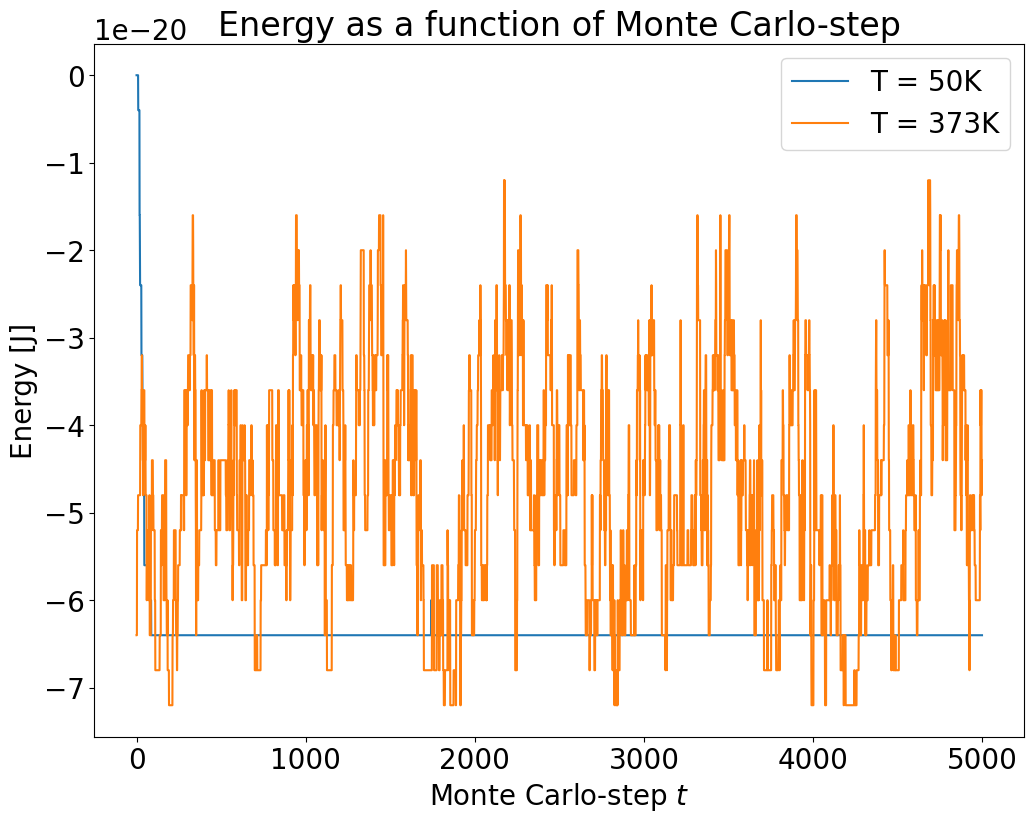

In [64]:
def plotEnergy(polymer, V, Ns, T_array):
    """
    Plot the energy of the polymers simulated with the metropolisAlgorithm for different temperatures
    Input:
    polymer: The polymer to simulate the metropolisAlgorithm on with various temperatures
    V: The potential matrix for the metropolisAlgorithm
    NS: The number of successfull rotations for the metropolisAlgorithm
    T_array: The temperatures to simulate the metropolisAlgorithm on
    """
    polymers = []
    plt.figure(figsize = (12, 9))
    """
    Plotting the energy-arrays for each temperature
    """
    for T in T_array:
        polymer, E_array = metropolisAlgorithm(polymer, V, Ns, T)
        polymers.append(polymer)
        plt.plot(E_array, label = f'T = {T}K')
    """
    Customizing the plot
    """
    plt.xlabel(r'Monte Carlo-step $t$')
    plt.ylabel('Energy [J]')
    plt.title('Energy as a function of Monte Carlo-step')
    plt.legend()
    plt.show()
    """
    Returnin the achieved polymers for a later problem
    """
    return polymers

N = 30
V = makePotential(30, -4 * 10 ** (-21))
polymer = plotEnergy(createPolymer(N), V, 5000, [50, 373])

The plot shows that the energy for the polymer at a lower temperature $T=50K$ often varies less than the energy of the polymer at the higher temperature $T=373K$. The polymer at $T=50K$ has a quick drop in the energy after a couple Monte Carlo-steps, before it stabilizes at a local energy minimum. In some simulations, the polymers manages to break out of the local energy minimum and the energy drops further to another local energy minimum.

The polymer at $T=373K$, starts oscillating. Even though the polymer at a higher temperature reaches lower energies throughout the simulation, the polymer at lower temperatures often has a lower energy average, as it stabilizes at a low energy instead of oscillating between lower and higher energies. This makes sense, since temperature is just a measurement of movement, and higher temperatures often indicate more possible states.

The following code block illustrates how these two polymers look after the simulation, as mentioned in task **2c)**.

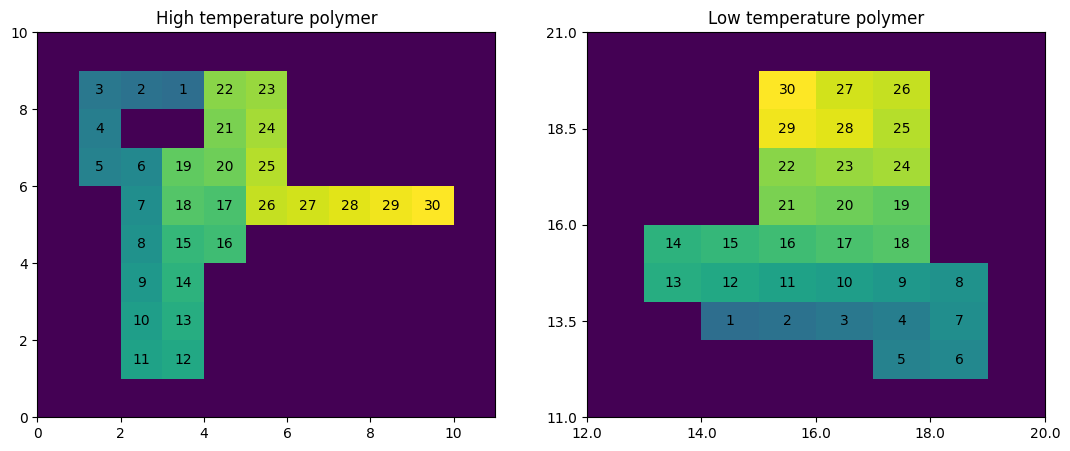

In [65]:
V=makePotential(30,-4*10**(-21))
polymer_high_temp, E_array_high_temp=metropolisAlgorithm(createPolymer(30),V,5000,350)
polymer_low_temp, E_array_low_temp=metropolisAlgorithm(createPolymer(30),V,5000,75)

plt.rcParams.update({'font.size': 10}) # change font-size of the plot
multiplePlotsPolymers(polymer_high_temp, polymer_low_temp, "High temperature polymer", "Low temperature polymer")
plt.rcParams.update({'font.size': 20}) # change font-size of the plot

# illustrationPolymer(polymer)
# print(E_array[-1])

Until now, we've looked at potential matrices $V$ where all non-zero values are the same. As instructed in task **2d)**, the following function $\texttt{makeSymmetricPotential}$ creates a potential matrix that 

*beskrivelse av hva slags V vi ender med*

In [66]:
def makeSymmetricPotential(N, generalValue, scaling, tuplesToScale):
    """
    Input:
    N: The length of the polymer
    generalValue: the value of the cells which are neither 0 nor the interactions which are to be scaled
    scaling: the factor which the generalValue is multiplied with for the specified pairs
    tuplesToScale: the pairs which are to have a difference potential between them than the general value
    """

    potential = np.zeros((N,N)) + generalValue # Set the backround value
    """
    Ensure that the the potential between consecutive monomers and the monomers with themselves is 0
    """
    for i in range(N):
        potential[i,i] = 0
        if i > 0:
            potential[i-1,i] = 0
            potential[i,i-1] = 0
    """
    Scaling the tuples to scale, and ensuring that the matrix stays symmetric
    """
    for tup in tuplesToScale:
        potential[tup] = generalValue*scaling
        potential[tup[1],tup[0]] = generalValue*scaling
    return potential # returning the potential
# N = 15
# V = createFunkyPotential(N,-4*10**(-21), 100, [(0,N-1),(1,N-2),(2,N-3),(3,N-4),(4,N-5),(N-1,N-4)])
# pol, array = metropolisalgoritmen(createPolymer(N), V, 100, 50)
# print(calculateEnergy(pol,V))
# print(min(array))
# illustrationPolymer(pol)


# 2e)

In [67]:
def computeEnergyStats(V, T, Ns=1500, N=30):                            # Ns must be over 1000
    """
    Initialize and simulate the metropolisAlgorithm for a polymer of length N
    Input:
    V: The potential matrix of which to simulate the metropolisAlgorithm on
    T: The temperature at which the metropolisAlgorithm is to take place
    Ns: The number of rotatations to make in the metropolisAlgorithm, must be over 1000
    N: The length of the polymer
    """
    polymer = createPolymer(N)
    _, energy = metropolisAlgorithm(polymer, V, Ns, T)
    """
    Restricting the energy-data contributing to the expected value and standard deviation to the values after a 1000, to give the polymer time
    to stabilize
    """
    importantEnergy = energy[1000:]                                            
    return np.average(importantEnergy), np.std(importantEnergy, ddof=1)

def plotEnergyStats(V,lowTemp, highTemp, tempStep, Ns=1500, N=30):
    """
    Plot the expected value and standard deviation of the energy a polymer in a given range of temperatures
    
    Input:
    V: The potential matrix to simulate the metropolisAlgorithm on.
    lowTemp: The temperature at which to start the temperature range of which the metropolisAlgorithm is to be simulated with.
    highTemp: The temperature at which to end the temperature range.
    tempStep: The difference between two consecutive values in the temperature range
    Ns: The number of succesfull rotations to be done in the metropolisAlgorithm, must be greater than 1000
    N: The length of the polymer to be simulated
    """

    tempArray = np.arange(lowTemp,highTemp,tempStep)
    """
    Get the expectedvalue and experimental standard deviation for energy as a function of temperature
    """
    expectedValue, standardDeviation = np.zeros(len(tempArray)), np.zeros(len(tempArray))
    for temp_index in range(len(tempArray)):
        expectedValue[temp_index], standardDeviation[temp_index] = computeEnergyStats(V, tempArray[temp_index], Ns, N)
    """
    Plot the information
    """
    plt.errorbar(tempArray, expectedValue, yerr = standardDeviation)
    plt.show()

# plotEnergyStats(V, lowTemp=10,highTemp=1000,TempStep=30)

# 2f)

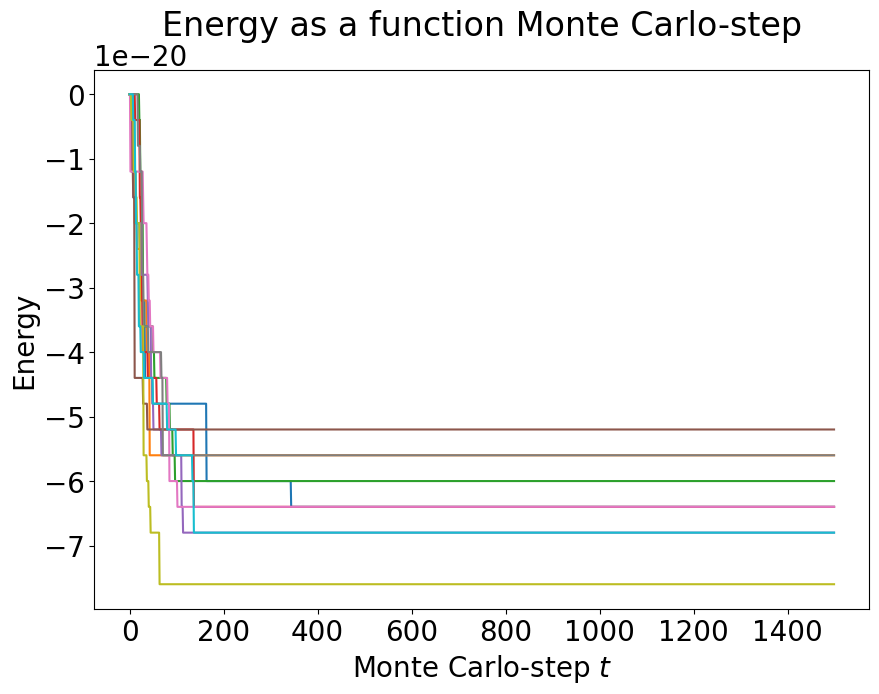

In [68]:
def plotEnergyLowTemp(V, T, Ns = 1500, N = 30):
    """
    Comparrison of the energy of different simulation of polymers at the same length and temperature
    Input:
    V: The potential matrix to simulate with
    T: The temperature to simulate at
    Ns: The number of succesful to complete
    N: The length of the polymers
    """
    plt.figure(figsize = (10, 7))
    
    """
    Simulate the metropolisAlgorithm 10 times and plotting the energy for each
    """
    for sim in range(10):
        polymer = createPolymer(N)
        _, energy = metropolisAlgorithm(polymer, V, Ns, T)
        plt.plot(energy)

    """
    Fixing the layout of the figure:
    """
    plt.xlabel(r'Monte Carlo-step $t$')
    plt.ylabel('Energy')
    plt.title('Energy as a function Monte Carlo-step')
    plt.show()

plotEnergyLowTemp(V, 20)

# 2g)

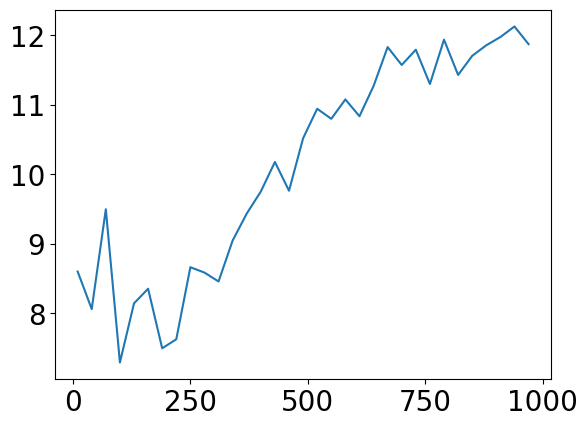

In [69]:
def computeDiameterStats(V, T, Ns=1500, N=30):
    """
    Compute the average diameter of the polymer after it has stabilised
    Input:
    V: The potential to simulate on
    T: The temperature at which to simulate
    Ns: The number of successfull rotations to achieve, must be greater than 1000
    N: The length of the polymer
    """
    polymer = createPolymer(N)
    """
    Get the diameter data from the simulation and discard the values before 1000 rotations so the polymer has stabilised a bit
    """                                                      
    _,_,diameter = metropolisAlgorithm(polymer, V, Ns, T, includeDiameter=True)      
    importantDiameter = diameter[1000:]                                             
    return np.average(importantDiameter)                                            
def getDiameterFromTemp(lowTemp, highTemp, tempStep, Ns=1500, N=30):
    """
    Find expected diameter for a range of temperatures between lowTemp and highTemp:
    Input:
    lowTemp: The temperature at which the range of temperature to simulate the metropolisAlgorithm starts
    highTemp: The temperature at which the range ends
    tempStep: The difference between consecutive temperatures in the range
    Ns: The number of successfull rotations for each simulation, must be greater than 1000
    N: The length of the polymer to simulate

    Create a random symmetric matrix with values between -6*10**(-21) and -2*10**(-21)
    """
    V = np.zeros((N,N))
    for i in range(N):
        for j in range(i-1):                                                        # To ensure that the diagonal and the lines directly above and below are 0
          V[i,j]=(np.random.uniform(-6,-2))*10**(-21)                               

    V=V+V.transpose()                                                               # Make it symmetric

    """
    Calculate the exepcted value and standard deviation a range of tempeartures
    """
    tempArray = np.arange(lowTemp,highTemp,tempStep)                                # Create a temperature array which contains the temperatures we are gonna measure
    expectedValue = np.zeros(len(tempArray))
    for index in range(len(tempArray)):
        expectedValue[index] = computeDiameterStats(V, tempArray[index], Ns, N)
    return tempArray, expectedValue
    
def plotDiameterStats(lowTemp, highTemp, tempStep, Ns=1500, N=30):
    """
    Plot the values found in getDiameterFromTemp.
    Input:
    Same explenation as above.
    """
    tempArray, expectedValue = getDiameterFromTemp(lowTemp,highTemp, tempStep, Ns, N)
    """
    Plot the expected value and standardDeviation
    """
    plt.plot(tempArray, expectedValue)
    plt.show()

plotDiameterStats(lowTemp=10, highTemp=1000, tempStep=30, Ns=3000, N=30)

# %timeit plotExpectedAndSTDDiameter(lowTemp=10, highTemp=1000, TempStep=30, Ns=3000, N=30)

# 2h)

In [70]:
def computeDiameterStatsV2(polymer, V, T, Ns=1500):
    """
    Identical to computeDiameterStats, just that it returns the polymer, input thus the same
    """

    polymer,_,diameter = metropolisAlgorithm(polymer, V, Ns, T, includeDiameter=True) 
    importantDiameter = diameter[1000:] # Note Ns > 10000

    """
    Returns the polymer and the average diameter of the polymer after the simulation has stabilised (After 1000 accomplished rotations)
    """
    return polymer, np.average(importantDiameter)



def getDiameterFromTempV2(lowTemp, highTemp, tempStep, Ns, N):
    """
    Purpose, the same as getDiameterFromTemp, just where the algorithm starts at the highTemp and reuse the polymer returned by each simulation.
    Input: 
    Explained in 2g) in getDiameterFromTemp 
    """
    
    polymer = createPolymer(N)  #Creating the polymer

    """
    Creating a random symmetrical matrix with values between -6*10**(-21) and -2*10**(-21)
    """
    V = np.zeros((N,N))
    for i in range(N):
        for j in range(i-1):
          V[i,j]=(np.random.uniform(-6,-2))*10**(-21)

    V=V+V.transpose()

    
    tempArray = np.arange(highTemp,lowTemp,-tempStep) #Creating a temperature array

    """
    Finding the expected diameter of the polymer at the given tempeartures
    """
    expectedValue = np.zeros(len(tempArray))
    for index in range(len(tempArray)):
        polymer, expectedValue[index]= computeDiameterStatsV2(polymer, V, tempArray[index], Ns)

    
    return tempArray, expectedValue



def plotComparisonDiameter(lowTemp, highTemp, tempStep, Ns = 1500, N = 30):
    """
    Plot the expected diameter as a function of temperature where one simulates a cooling process, and thus start at a high temperature and reuse
    the old polymer for the new simulation, while the other resets the polymer for each simulation.
    Input the same as plotDiameterStats
    """
    tempArray, expectedValue = getDiameterFromTempV2(lowTemp, highTemp, tempStep, Ns, N)
    plt.plot(tempArray, expectedValue, label = "Cooling polymer")

    """
    Plot of the expected diameter as a function of temperature where the polymer is reset to the default position for each simulation
    """
    tempArrayReset, expectedValueReset = getDiameterFromTemp(lowTemp, highTemp, tempStep, Ns, N)
    plt.plot(tempArrayReset, expectedValueReset, label = "Reset polymer")

    """
    Fixing the appearance of the plot
    """
    plt.legend()
    plt.xlabel("Temperature")
    plt.ylabel("Diameter")
    plt.show()

plotComparisonDiameter(lowTemp=10, highTemp=1000, tempStep=30, Ns=3000, N=30)
#%timeit plotExpectedAndSTDDiameterDownwardsVersion(lowTemp=10, highTemp=1000, tempStep=30, Ns=3000, N=30)

KeyboardInterrupt: 